In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.XAS_functions import *
from scipy.stats.stats import pearsonr


import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [2]:
pgroup='p21992'
runnumber = 168
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
jsonfile

run: 0168


'/sf/alvra/data/p21992/raw/run0168-MbCO_Jetscan_7128eV/meta/scan.json'

In [3]:
channel_diode_1 = 'SARES12-GES1:PR1_CH1_VAL_GET'
channel_diode_2 = 'SARES12-GES1:PR1_CH2_VAL_GET'

In [4]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero122
#######################################################################################################
from sfdata import SFScanInfo
try:    
    scan = SFScanInfo(jsonfile)
    scan = remove_JF_from_scan(scan)

    Signal_APD1, Signal_APD2, IzeroFEL, correlation1, correlation2, Position_mm = \
    XAS_scan_2diodes_static(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)
except:
    print ('==> json file not yet ready!! <==')

Processing: run0168-MbCO_Jetscan_7128eV
Step 51 of 51: Processing acq0051

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY    251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 251 / 251 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
125 shots out of 251 survived
125 shots out of 251 survived
Step 51 of 51: Processed acq0051
correlation Diode1 (all shots) = 0.9906866966345828
correlation Diode2 (all shots) = 0.9718903055972027
------------------------------
Processed 51 out of 51 files


## Plot only 1 diode

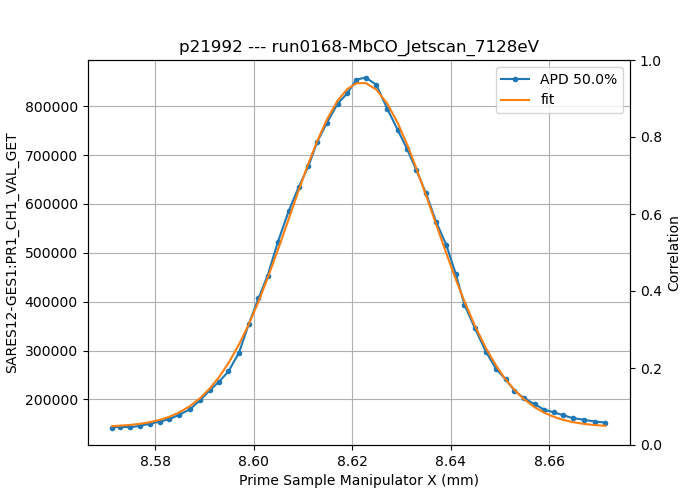

Center position = 8.622 mm
Width = 34.637 um


In [5]:
Int_APD1 = Signal_APD1[:,0]
err_low_APD1 = Signal_APD1[:,1]
err_high_APD1 = Signal_APD1[:,2]

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

fit = Fit(gaussian, estimate_gaussian_parameters)
fit.estimate(Position_mm, Int_APD1)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
fit.fit(Position_mm, Int_APD1)                  # calculate the fit
Int_fit = fit.eval(Position_mm)            # evaluate the curve for plotting
center = fit.popt[0]
width = fit.popt[2]*2.355

fig = plt.figure(figsize = (7,5))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler
plt.title(titlestring)

lns1 = ax1.plot(Position_mm, Int_APD1, label='APD {}%'.format(quantile_corr*100),marker='.')
lns2 = ax1.plot(Position_mm, Int_fit, label = 'fit')
#lns3 = ax2.plot(Position_mm, correlation1, label='correlation')
#ax1.fill_between(Position_mm, err_low_APD1, err_high_APD1, color='lightblue')

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel(detector_XAS_1)
ax2.set_ylabel("Correlation")

leg = lns1 + lns2 #+ lns3
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')

ax1.grid()
plt.show()

print("Center position = {:.3f} mm".format(center))
print("Width = {:.3f} um".format(width*1000))
#print("Bandwidth = {} %".format(np.abs(np.round(width,3))/np.round(center,3)*100))

## Plot 2 diodes

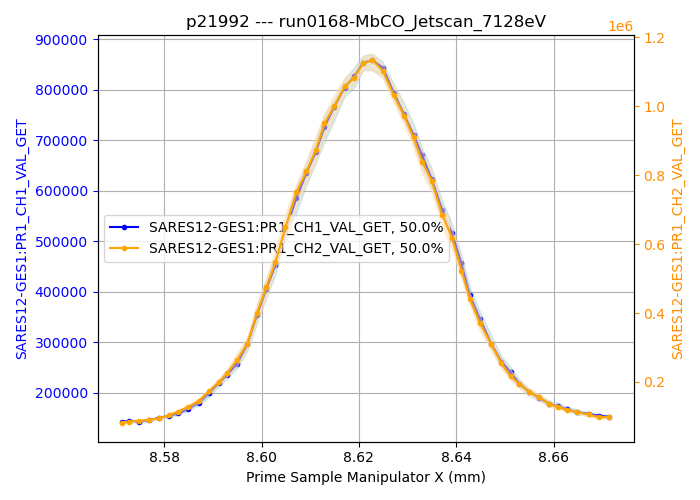

In [6]:
Int_APD1 = Signal_APD1[:,0]
err_low_APD1 = Signal_APD1[:,1]
err_high_APD1 = Signal_APD1[:,2]

Int_APD2 = Signal_APD2[:,0]
err_low_APD2 = Signal_APD2[:,1]
err_high_APD2 = Signal_APD2[:,2]

###########################################

fit = Fit(gaussian, estimate_gaussian_parameters)

fit.estimate(Position_mm, Int_APD1)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
fit.fit(Position_mm, Int_APD1)                  # calculate the fit
Int_fit1 = fit.eval(Position_mm)            # evaluate the curve for plotting
center1 = fit.popt[0]
width1 = fit.popt[2]*2.355

fit.estimate(Position_mm, Int_APD2)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
fit.fit(Position_mm, Int_APD2)                  # calculate the fit
Int_fit2 = fit.eval(Position_mm)            # evaluate the curve for plotting
center2 = fit.popt[0]
width2 = fit.popt[2]*2.355

###########################################

fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

lns1 = ax1.plot(Position_mm, Int_APD1, label=detector_XAS_1+', {}%'.format(quantile_corr*100),marker='.', color='b')
ax1.fill_between(Position_mm, err_low_APD1, err_high_APD1, color='lightblue', alpha = 0.5)
#ax1.plot(Position_mm, Int_fit1, color='navy')

lns2 = ax2.plot(Position_mm, Int_APD2, label=detector_XAS_2+', {}%'.format(quantile_corr*100),marker='.', color='orange')
ax2.fill_between(Position_mm, err_low_APD2, err_high_APD2, color='navajowhite', alpha = 0.5)
#ax2.plot(Position_mm, Int_fit2, color='coral')


plt.title(titlestring)

ax1.set_xlabel("{} ({})".format(label, units))

#ax1.set_ylabel ("Normalized intensity diode1")
ax1.set_ylabel(detector_XAS_1)
ax1.tick_params(axis='y', colors='b')
ax1.yaxis.label.set_color('b')

#ax2.set_ylabel ("Normalized intensity diode2")
ax2.set_ylabel(detector_XAS_2)
ax2.tick_params(axis='y', colors='darkorange')
ax2.yaxis.label.set_color('darkorange')


leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')
#ax1.axvline(6.615)
ax1.grid()
plt.tight_layout()
plt.show()